# Theory

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from importlib import reload

import tensorflow as tf

In [2]:
import domain
import network
import PINN

## Sampling points in the domain

<IPython.core.display.Javascript object>


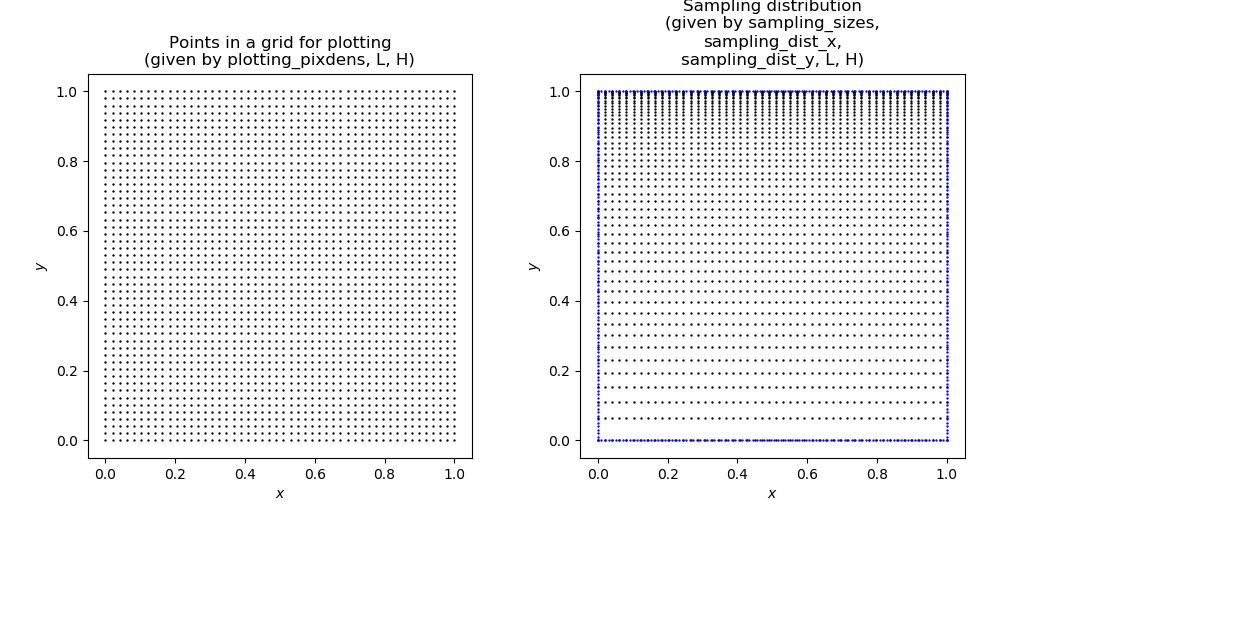

In [3]:
reload(domain)

L     = 1
H     = 1
alpha = 5

def scatter_samples(ax, samples, c = 'k'):
    ax.scatter(samples[:,0],samples[:,1], s = 0.5, color = c)

D    = domain.rectangular_domain(L=L, H=H, alpha = alpha, plotting_pixdens = 50, sampling_sizes = (50,50),
                                 sampling_dist_y = lambda y: np.sin(np.pi*y/2)**0.8)

fig, axs = plt.subplots(1,2, figsize = (10*L,5*H))

axs[0].set_title("Points in a grid for plotting\n(given by plotting_pixdens, L, H)")
scatter_samples(axs[0],D.plotting_grid)

D.update_samples()

axs[1].set_title("Sampling distribution\n(given by sampling_sizes,\nsampling_dist_x,\nsampling_dist_y, L, H)")
scatter_samples(axs[1],D.interior_samples)
scatter_samples(axs[1],D.boundary_samples, c = 'b')

for ax in axs:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect('equal','box')
    
fig.tight_layout()
fig.canvas.draw();

In [36]:
reload(network)
reload(PINN)

Model = network.construct_model_stokesflow(hidden_layer_widths = np.array(7*[10]),
                                           activation_function = tf.nn.tanh)

Optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,
                                     beta_1=0.99,
                                     epsilon=1e-1)

BCs_v1    = 4*[lambda x: 0*x]
BCs_v1[2] = lambda x: 0*x +1

# Standard we have f = 0
# The loss weights are in the order incompressibility, PDE, boundaries

NN = PINN.PINN_object_stokesflow(D, Model, Optimizer, BCs_v1 = BCs_v1, loss_weights = [10,1,10])

<IPython.core.display.Javascript object>


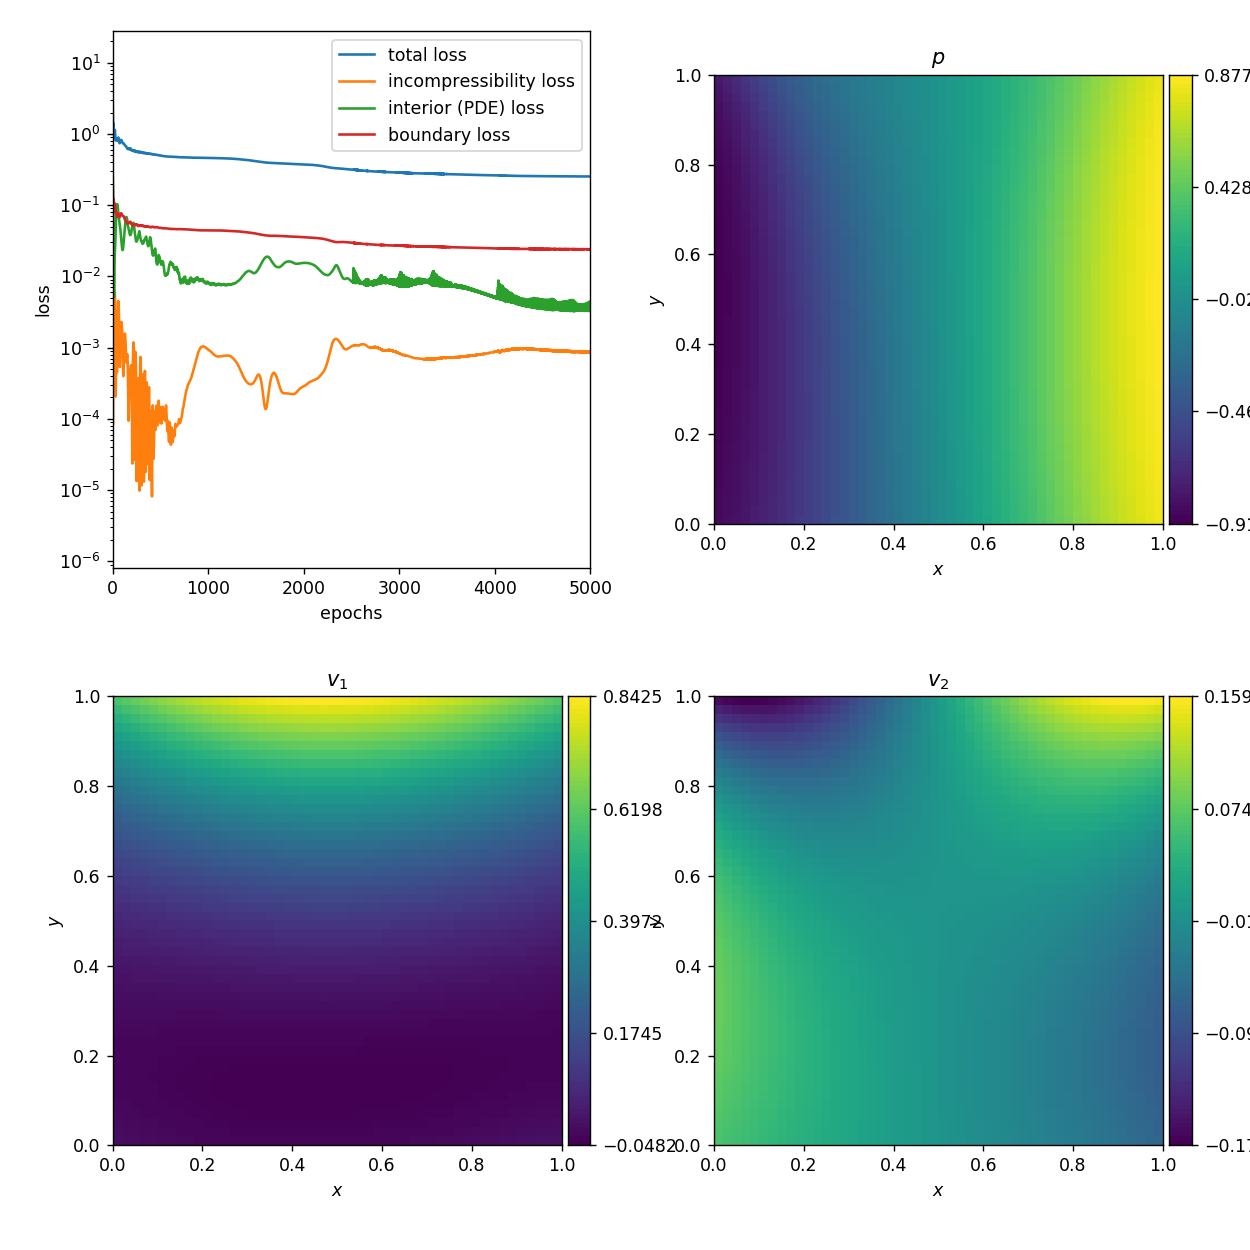

In [37]:
NN.fit(n_epochs = 5000,
       plot_update_interval = 50);

<IPython.core.display.Javascript object>


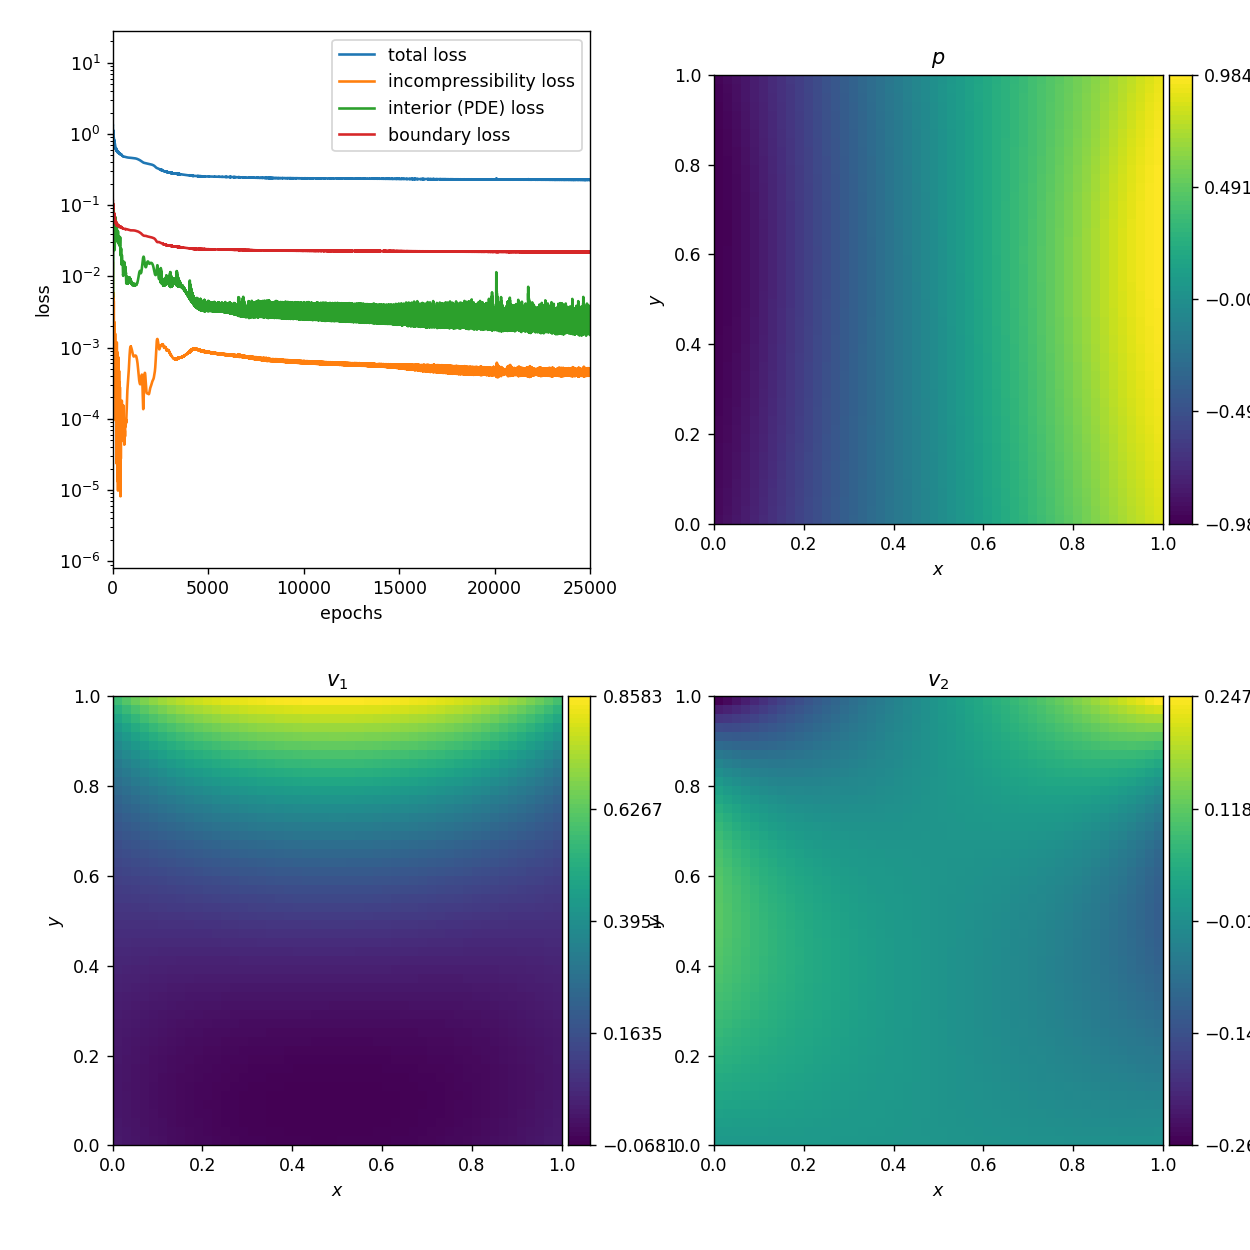

In [38]:
NN.fit(n_epochs = 20000,
       plot_update_interval = 50);

In [39]:
plt.savefig("Stokesflow.png")